In [1]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
from ROOT import TFile, TTree, TChain
print("All classes initialized succesfully.")

Welcome to JupyROOT 6.18/04
All classes initialized succesfully.


In [4]:
sigChan = TChain("varTree")
sigChan.Add("signal.root")
bkgChan = TChain("varTree")
bkgChan.Add("background.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [5]:
sigChan.Print()
bkgChan.Print()

******************************************************************************
*Chain   :varTree   : signal.root                                            *
******************************************************************************
******************************************************************************
*Tree    :varTree   : Input Variables List for Algorithms                    *
*Entries :    44440 : Total =         3213746 bytes  File  Size =    2732257 *
*        :          : Tree compression factor =   1.17                       *
******************************************************************************
*Br    0 :HtJet     : HtJet/D                                                *
*Entries :    44440 : Total  Size=     356973 bytes  File Size  =      24645 *
*Baskets :       12 : Basket Size=      32000 bytes  Compression=  14.46     *
*............................................................................*
*Br    1 :dRLL      : dRLL/D                        

In [6]:
# Read input data from root files
sigSampleSize = sigChan.GetEntries()
bkgSampleSize = bkgChan.GetEntries()
print(sigSampleSize)
print(bkgSampleSize)

44440
4108


In [7]:
# Convert the input data to matrices
sigFull = sigChan.AsMatrix()
bkgFull = bkgChan.AsMatrix()
print(sigFull[0])
print(sigFull.shape)
print(bkgFull.shape)

[ 0.          2.49833166  0.80792055  3.60755951  4.04035573  0.48130491
  0.32805805  0.29058502 70.49661585]
(44440, 9)
(4108, 9)


In [8]:
# Choose 20% of the data for testing and 80% of the data for training
sigTrain = sigFull[0:int(0.8*sigFull.shape[0])][:]
bkgTrain = bkgFull[0:int(0.8*bkgFull.shape[0])][:]
sigTest = sigFull[int(0.8*sigFull.shape[0]):][:]
bkgTest = bkgFull[int(0.8*bkgFull.shape[0]):][:]
print(sigTrain.shape)
print(bkgTrain.shape)
print(sigTest.shape)
print(bkgTest.shape)

(35552, 9)
(3286, 9)
(8888, 9)
(822, 9)


In [9]:
# Set a scaler for input features
scaler = StandardScaler()
scaler_input = np.concatenate((sigTrain,bkgTrain))
print(scaler.fit(scaler_input))
print(scaler.mean_)
joblib.dump(scaler, "scaler.save")

StandardScaler(copy=True, with_mean=True, with_std=True)
[ 3.26113929  2.85206341  0.71608697  7.10178975  2.41076365  1.64264783
  0.2280836   0.07920158 57.8950444 ]


NameError: name 'joblib' is not defined

In [58]:
# Build the model
per = m.Sequential()
per.add(l.Dense(18, input_dim=sigTrain.shape[1], activation='relu'))
per.add(l.Dropout(rate=0.2))
per.add(l.Dense(18, activation='relu'))
per.add(l.Dropout(rate=0.2))
per.add(l.Dense(2, activation='softmax'))
print("Model building complete!!!")

per.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

Model building complete!!!


In [59]:
# Loop to change the training sample every time
# by randomly choosing from the avalaible sample space.
# Make sure to run atleast so that each and every event has been used once.

nShuffleRun = 10
trainingSampleSize = sigTrain.shape[0] if sigTrain.shape[0]<bkgTrain.shape[0] else bkgTrain.shape[0]
testSampleSize = sigTest.shape[0] if sigTest.shape[0]<bkgTest.shape[0] else bkgTest.shape[0]

print(trainingSampleSize)
print(testSampleSize)

3286
822


In [60]:
nEpochs = 100

lossTrain = []
lossTest = []
accTrain = []
accTest = []

for iterTrain in np.arange(nShuffleRun):
    
    sigTrainSampleRange = np.arange(sigTrain.shape[0])
    sigTrainSampleIndex = np.random.choice(sigTrainSampleRange, trainingSampleSize, replace=False)
    sigTrainChosen = sigTrain[sigTrainSampleIndex,:]
    bkgTrainSampleRange = np.arange(bkgTrain.shape[0])
    bkgTrainSampleIndex = np.random.choice(bkgTrainSampleRange, trainingSampleSize, replace=False)
    bkgTrainChosen = bkgTrain[bkgTrainSampleIndex,:]
    
    sigTestSampleRange = np.arange(sigTest.shape[0])
    sigTestSampleIndex = np.random.choice(sigTestSampleRange, testSampleSize, replace=False)
    sigTestChosen = sigTest[sigTestSampleIndex,:]
    bkgTestSampleRange = np.arange(bkgTest.shape[0])
    bkgTestSampleIndex = np.random.choice(bkgTestSampleRange, testSampleSize, replace=False)
    bkgTestChosen = bkgTest[bkgTestSampleIndex,:]
    
    #print(sigTrainChosen.shape)
    #print(bkgTrainChosen.shape)
    
    # Concatenate the signal and background with proper labels
    x = np.concatenate((sigTrainChosen,bkgTrainChosen))
    y = np.matrix([[1,0]]*sigTrainChosen.shape[0]+[[0,1]]*bkgTrainChosen.shape[0])
    x_test = np.concatenate((sigTestChosen,bkgTestChosen))
    y_test = np.matrix([[1,0]]*sigTestChosen.shape[0]+[[0,1]]*bkgTestChosen.shape[0])
    print("Feature Space: ",x.shape)
    
    # Randomize the training samples
    arr = np.arange(x.shape[0])
    np.random.shuffle(arr)
    x = x[arr,:]
    y = y[arr,:]
    
    # Scale the input features
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)
    
    history = per.fit(x, 
                      y, 
                      validation_data=(x_test, y_test), 
                      epochs=nEpochs, 
                      batch_size=int(0.1*x.shape[0]))
    
    lossTrain.extend(history.history['loss'])
    lossTest.extend(history.history['val_loss'])
    accTrain.extend(history.history['accuracy'])
    accTest.extend(history.history['val_accuracy'])


Feature Space:  (6572, 9)
Train on 6572 samples, validate on 1644 samples
Epoch 1/100
6572/6572 [==============================] - 1s 104us/sample - loss: 0.8913 - accuracy: 0.4822 - val_loss: 1.0371 - val_accuracy: 0.5474
Epoch 2/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.7632 - accuracy: 0.5234 - val_loss: 0.9013 - val_accuracy: 0.5821
Epoch 3/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.7009 - accuracy: 0.5606 - val_loss: 0.8093 - val_accuracy: 0.6241
Epoch 4/100
6572/6572 [==============================] - 0s 14us/sample - loss: 0.6672 - accuracy: 0.5802 - val_loss: 0.7434 - val_accuracy: 0.6588
Epoch 5/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.6410 - accuracy: 0.6042 - val_loss: 0.6871 - val_accuracy: 0.6800
Epoch 6/100
6572/6572 [==============================] - 0s 12us/sample - loss: 0.6233 - accuracy: 0.6228 - val_loss: 0.6381 - val_accuracy: 0.6953
Epoch 7/100
6572/6572 [===============

6572/6572 [==============================] - 0s 9us/sample - loss: 0.4187 - accuracy: 0.7911 - val_loss: 0.3824 - val_accuracy: 0.8035
Epoch 56/100
6572/6572 [==============================] - 0s 12us/sample - loss: 0.4209 - accuracy: 0.7931 - val_loss: 0.3815 - val_accuracy: 0.8054
Epoch 57/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.4152 - accuracy: 0.7906 - val_loss: 0.3801 - val_accuracy: 0.8066
Epoch 58/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.4163 - accuracy: 0.7943 - val_loss: 0.3798 - val_accuracy: 0.8114
Epoch 59/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.4103 - accuracy: 0.8011 - val_loss: 0.3781 - val_accuracy: 0.8096
Epoch 60/100
6572/6572 [==============================] - 0s 17us/sample - loss: 0.4081 - accuracy: 0.7958 - val_loss: 0.3776 - val_accuracy: 0.8120
Epoch 61/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.4123 - accuracy: 0.7981 - val_loss: 0.

Epoch 10/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3737 - accuracy: 0.8176 - val_loss: 0.3506 - val_accuracy: 0.8382
Epoch 11/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3738 - accuracy: 0.8205 - val_loss: 0.3508 - val_accuracy: 0.8388
Epoch 12/100
6572/6572 [==============================] - 0s 6us/sample - loss: 0.3704 - accuracy: 0.8212 - val_loss: 0.3506 - val_accuracy: 0.8388
Epoch 13/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3769 - accuracy: 0.8174 - val_loss: 0.3530 - val_accuracy: 0.8352
Epoch 14/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3717 - accuracy: 0.8240 - val_loss: 0.3533 - val_accuracy: 0.8345
Epoch 15/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3717 - accuracy: 0.8201 - val_loss: 0.3521 - val_accuracy: 0.8345
Epoch 16/100
6572/6572 [==============================] - 0s 6us/sample - loss: 0.3708 - accuracy: 0.8220 - va

6572/6572 [==============================] - 0s 8us/sample - loss: 0.3560 - accuracy: 0.8316 - val_loss: 0.3363 - val_accuracy: 0.8449
Epoch 66/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3510 - accuracy: 0.8308 - val_loss: 0.3365 - val_accuracy: 0.8443
Epoch 67/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3527 - accuracy: 0.8325 - val_loss: 0.3363 - val_accuracy: 0.8449
Epoch 68/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3515 - accuracy: 0.8328 - val_loss: 0.3356 - val_accuracy: 0.8431
Epoch 69/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3554 - accuracy: 0.8274 - val_loss: 0.3352 - val_accuracy: 0.8437
Epoch 70/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3570 - accuracy: 0.8273 - val_loss: 0.3353 - val_accuracy: 0.8449
Epoch 71/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3512 - accuracy: 0.8291 - val_loss: 0.3352

Epoch 20/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3476 - accuracy: 0.8376 - val_loss: 0.3285 - val_accuracy: 0.8498
Epoch 21/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3418 - accuracy: 0.8334 - val_loss: 0.3278 - val_accuracy: 0.8540
Epoch 22/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3436 - accuracy: 0.8395 - val_loss: 0.3294 - val_accuracy: 0.8522
Epoch 23/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3451 - accuracy: 0.8367 - val_loss: 0.3308 - val_accuracy: 0.8498
Epoch 24/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3434 - accuracy: 0.8378 - val_loss: 0.3309 - val_accuracy: 0.8510
Epoch 25/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3430 - accuracy: 0.8425 - val_loss: 0.3305 - val_accuracy: 0.8516
Epoch 26/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3452 - accuracy: 0.8364 - v

6572/6572 [==============================] - 0s 7us/sample - loss: 0.3371 - accuracy: 0.8419 - val_loss: 0.3267 - val_accuracy: 0.8498
Epoch 76/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3362 - accuracy: 0.8446 - val_loss: 0.3265 - val_accuracy: 0.8504
Epoch 77/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3365 - accuracy: 0.8422 - val_loss: 0.3286 - val_accuracy: 0.8522
Epoch 78/100
6572/6572 [==============================] - 0s 6us/sample - loss: 0.3404 - accuracy: 0.8379 - val_loss: 0.3287 - val_accuracy: 0.8516
Epoch 79/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3399 - accuracy: 0.8411 - val_loss: 0.3286 - val_accuracy: 0.8504
Epoch 80/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3353 - accuracy: 0.8418 - val_loss: 0.3281 - val_accuracy: 0.8510
Epoch 81/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.3347 - accuracy: 0.8469 - val_loss: 0.3274

Epoch 30/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3443 - accuracy: 0.8379 - val_loss: 0.3498 - val_accuracy: 0.8327
Epoch 31/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3478 - accuracy: 0.8386 - val_loss: 0.3497 - val_accuracy: 0.8352
Epoch 32/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3479 - accuracy: 0.8384 - val_loss: 0.3497 - val_accuracy: 0.8345
Epoch 33/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3456 - accuracy: 0.8396 - val_loss: 0.3492 - val_accuracy: 0.8339
Epoch 34/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3434 - accuracy: 0.8414 - val_loss: 0.3483 - val_accuracy: 0.8333
Epoch 35/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3431 - accuracy: 0.8418 - val_loss: 0.3481 - val_accuracy: 0.8309
Epoch 36/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3465 - accuracy: 0.8341 - 

6572/6572 [==============================] - 0s 7us/sample - loss: 0.3449 - accuracy: 0.8398 - val_loss: 0.3478 - val_accuracy: 0.8339
Epoch 86/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3422 - accuracy: 0.8401 - val_loss: 0.3477 - val_accuracy: 0.8339
Epoch 87/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3453 - accuracy: 0.8413 - val_loss: 0.3477 - val_accuracy: 0.8333
Epoch 88/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3423 - accuracy: 0.8431 - val_loss: 0.3476 - val_accuracy: 0.8321
Epoch 89/100
6572/6572 [==============================] - 0s 6us/sample - loss: 0.3397 - accuracy: 0.8425 - val_loss: 0.3475 - val_accuracy: 0.8327
Epoch 90/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3443 - accuracy: 0.8405 - val_loss: 0.3475 - val_accuracy: 0.8352
Epoch 91/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3423 - accuracy: 0.8401 - val_loss: 0.347

Epoch 40/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3404 - accuracy: 0.8389 - val_loss: 0.3324 - val_accuracy: 0.8516
Epoch 41/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3418 - accuracy: 0.8375 - val_loss: 0.3322 - val_accuracy: 0.8522
Epoch 42/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3427 - accuracy: 0.8392 - val_loss: 0.3320 - val_accuracy: 0.8540
Epoch 43/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3385 - accuracy: 0.8378 - val_loss: 0.3319 - val_accuracy: 0.8510
Epoch 44/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3379 - accuracy: 0.8440 - val_loss: 0.3325 - val_accuracy: 0.8485
Epoch 45/100
6572/6572 [==============================] - 0s 6us/sample - loss: 0.3422 - accuracy: 0.8390 - val_loss: 0.3335 - val_accuracy: 0.8498
Epoch 46/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3428 - accuracy: 0.8395 - val

6572/6572 [==============================] - 0s 4us/sample - loss: 0.3383 - accuracy: 0.8407 - val_loss: 0.3314 - val_accuracy: 0.8473
Epoch 96/100
6572/6572 [==============================] - 0s 3us/sample - loss: 0.3390 - accuracy: 0.8407 - val_loss: 0.3308 - val_accuracy: 0.8479
Epoch 97/100
6572/6572 [==============================] - 0s 3us/sample - loss: 0.3429 - accuracy: 0.8424 - val_loss: 0.3305 - val_accuracy: 0.8498
Epoch 98/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3352 - accuracy: 0.8414 - val_loss: 0.3309 - val_accuracy: 0.8485
Epoch 99/100
6572/6572 [==============================] - 0s 3us/sample - loss: 0.3366 - accuracy: 0.8448 - val_loss: 0.3341 - val_accuracy: 0.8467
Epoch 100/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3341 - accuracy: 0.8428 - val_loss: 0.3342 - val_accuracy: 0.8467
Feature Space:  (6572, 9)
Train on 6572 samples, validate on 1644 samples
Epoch 1/100
6572/6572 [===========================

Epoch 50/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3451 - accuracy: 0.8416 - val_loss: 0.3408 - val_accuracy: 0.8400
Epoch 51/100
6572/6572 [==============================] - 0s 5us/sample - loss: 0.3411 - accuracy: 0.8401 - val_loss: 0.3420 - val_accuracy: 0.8376
Epoch 52/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3430 - accuracy: 0.8378 - val_loss: 0.3408 - val_accuracy: 0.8388
Epoch 53/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3432 - accuracy: 0.8381 - val_loss: 0.3408 - val_accuracy: 0.8394
Epoch 54/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3444 - accuracy: 0.8398 - val_loss: 0.3421 - val_accuracy: 0.8431
Epoch 55/100
6572/6572 [==============================] - 0s 4us/sample - loss: 0.3408 - accuracy: 0.8386 - val_loss: 0.3415 - val_accuracy: 0.8400
Epoch 56/100
6572/6572 [==============================] - 0s 3us/sample - loss: 0.3469 - accuracy: 0.8392 - val_

6572/6572 [==============================] - 0s 12us/sample - loss: 0.3358 - accuracy: 0.8428 - val_loss: 0.3285 - val_accuracy: 0.8473
Epoch 5/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3422 - accuracy: 0.8392 - val_loss: 0.3275 - val_accuracy: 0.8461
Epoch 6/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3330 - accuracy: 0.8440 - val_loss: 0.3272 - val_accuracy: 0.8461
Epoch 7/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3387 - accuracy: 0.8411 - val_loss: 0.3272 - val_accuracy: 0.8467
Epoch 8/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3355 - accuracy: 0.8421 - val_loss: 0.3267 - val_accuracy: 0.8461
Epoch 9/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3331 - accuracy: 0.8460 - val_loss: 0.3261 - val_accuracy: 0.8461
Epoch 10/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3340 - accuracy: 0.8439 - val_loss: 0.3258 -

6572/6572 [==============================] - 0s 7us/sample - loss: 0.3328 - accuracy: 0.8454 - val_loss: 0.3277 - val_accuracy: 0.8455
Epoch 60/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3332 - accuracy: 0.8442 - val_loss: 0.3271 - val_accuracy: 0.8467
Epoch 61/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3361 - accuracy: 0.8419 - val_loss: 0.3271 - val_accuracy: 0.8473
Epoch 62/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3327 - accuracy: 0.8416 - val_loss: 0.3273 - val_accuracy: 0.8479
Epoch 63/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3341 - accuracy: 0.8428 - val_loss: 0.3268 - val_accuracy: 0.8473
Epoch 64/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3283 - accuracy: 0.8462 - val_loss: 0.3274 - val_accuracy: 0.8443
Epoch 65/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3348 - accuracy: 0.8449 - val_loss: 0.3273 

Epoch 14/100
6572/6572 [==============================] - 0s 12us/sample - loss: 0.3351 - accuracy: 0.8428 - val_loss: 0.3250 - val_accuracy: 0.8431
Epoch 15/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3385 - accuracy: 0.8410 - val_loss: 0.3265 - val_accuracy: 0.8406
Epoch 16/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3350 - accuracy: 0.8411 - val_loss: 0.3227 - val_accuracy: 0.8461
Epoch 17/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3333 - accuracy: 0.8416 - val_loss: 0.3222 - val_accuracy: 0.8479
Epoch 18/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3333 - accuracy: 0.8418 - val_loss: 0.3211 - val_accuracy: 0.8491
Epoch 19/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3362 - accuracy: 0.8410 - val_loss: 0.3212 - val_accuracy: 0.8473
Epoch 20/100
6572/6572 [==============================] - 0s 8us/sample - loss: 0.3397 - accuracy: 0.8442 - val

6572/6572 [==============================] - 0s 7us/sample - loss: 0.3313 - accuracy: 0.8446 - val_loss: 0.3213 - val_accuracy: 0.8540
Epoch 70/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3279 - accuracy: 0.8500 - val_loss: 0.3221 - val_accuracy: 0.8504
Epoch 71/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3300 - accuracy: 0.8449 - val_loss: 0.3226 - val_accuracy: 0.8485
Epoch 72/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3321 - accuracy: 0.8443 - val_loss: 0.3204 - val_accuracy: 0.8516
Epoch 73/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3341 - accuracy: 0.8411 - val_loss: 0.3185 - val_accuracy: 0.8546
Epoch 74/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3325 - accuracy: 0.8446 - val_loss: 0.3175 - val_accuracy: 0.8540
Epoch 75/100
6572/6572 [==============================] - 0s 6us/sample - loss: 0.3338 - accuracy: 0.8411 - val_loss: 0.31

Epoch 24/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3391 - accuracy: 0.8396 - val_loss: 0.3318 - val_accuracy: 0.8455
Epoch 25/100
6572/6572 [==============================] - 0s 6us/sample - loss: 0.3368 - accuracy: 0.8381 - val_loss: 0.3328 - val_accuracy: 0.8449
Epoch 26/100
6572/6572 [==============================] - 0s 13us/sample - loss: 0.3423 - accuracy: 0.8369 - val_loss: 0.3337 - val_accuracy: 0.8461
Epoch 27/100
6572/6572 [==============================] - 0s 16us/sample - loss: 0.3353 - accuracy: 0.8407 - val_loss: 0.3308 - val_accuracy: 0.8485
Epoch 28/100
6572/6572 [==============================] - 0s 16us/sample - loss: 0.3373 - accuracy: 0.8424 - val_loss: 0.3289 - val_accuracy: 0.8467
Epoch 29/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.3388 - accuracy: 0.8392 - val_loss: 0.3272 - val_accuracy: 0.8485
Epoch 30/100
6572/6572 [==============================] - 0s 12us/sample - loss: 0.3348 - accuracy: 0.8431 -

6572/6572 [==============================] - 0s 9us/sample - loss: 0.3396 - accuracy: 0.8390 - val_loss: 0.3263 - val_accuracy: 0.8510
Epoch 80/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3353 - accuracy: 0.8398 - val_loss: 0.3261 - val_accuracy: 0.8504
Epoch 81/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3343 - accuracy: 0.8413 - val_loss: 0.3257 - val_accuracy: 0.8516
Epoch 82/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3373 - accuracy: 0.8456 - val_loss: 0.3269 - val_accuracy: 0.8498
Epoch 83/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3336 - accuracy: 0.8439 - val_loss: 0.3275 - val_accuracy: 0.8479
Epoch 84/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3319 - accuracy: 0.8396 - val_loss: 0.3271 - val_accuracy: 0.8491
Epoch 85/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3385 - accuracy: 0.8428 - val_loss: 0.33

Epoch 34/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.3358 - accuracy: 0.8433 - val_loss: 0.3353 - val_accuracy: 0.8352
Epoch 35/100
6572/6572 [==============================] - 0s 12us/sample - loss: 0.3323 - accuracy: 0.8422 - val_loss: 0.3345 - val_accuracy: 0.8352
Epoch 36/100
6572/6572 [==============================] - 0s 11us/sample - loss: 0.3312 - accuracy: 0.8436 - val_loss: 0.3345 - val_accuracy: 0.8449
Epoch 37/100
6572/6572 [==============================] - 0s 16us/sample - loss: 0.3344 - accuracy: 0.8367 - val_loss: 0.3352 - val_accuracy: 0.8437
Epoch 38/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.3399 - accuracy: 0.8425 - val_loss: 0.3390 - val_accuracy: 0.8431
Epoch 39/100
6572/6572 [==============================] - 0s 14us/sample - loss: 0.3351 - accuracy: 0.8398 - val_loss: 0.3391 - val_accuracy: 0.8449
Epoch 40/100
6572/6572 [==============================] - 0s 12us/sample - loss: 0.3353 - accuracy: 0.8428

6572/6572 [==============================] - 0s 10us/sample - loss: 0.3301 - accuracy: 0.8413 - val_loss: 0.3316 - val_accuracy: 0.8376
Epoch 90/100
6572/6572 [==============================] - 0s 9us/sample - loss: 0.3322 - accuracy: 0.8439 - val_loss: 0.3309 - val_accuracy: 0.8394
Epoch 91/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3304 - accuracy: 0.8446 - val_loss: 0.3308 - val_accuracy: 0.8406
Epoch 92/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3332 - accuracy: 0.8437 - val_loss: 0.3308 - val_accuracy: 0.8394
Epoch 93/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3335 - accuracy: 0.8411 - val_loss: 0.3313 - val_accuracy: 0.8418
Epoch 94/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.3369 - accuracy: 0.8405 - val_loss: 0.3299 - val_accuracy: 0.8412
Epoch 95/100
6572/6572 [==============================] - 0s 7us/sample - loss: 0.3354 - accuracy: 0.8424 - val_loss: 0.

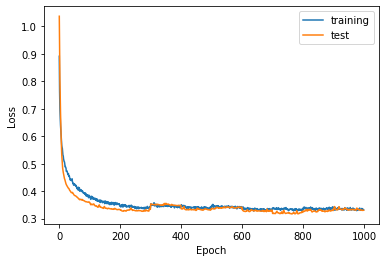

In [61]:
# Training Curve
plt.clf()
plt.plot(lossTrain, label='training')
plt.plot(lossTest, label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.pdf")

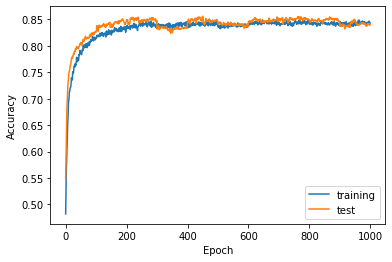

In [62]:
plt.clf()
plt.plot(accTrain, label='training')
plt.plot(accTest, label='test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.pdf")